<a href="https://colab.research.google.com/github/satoruk-icepp/MEG2XEC/blob/master/MEG2GAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%%writefile .comet.config
[comet]
api_key=mIel5ZAPOioTs0Cij75dSSQXs
logging_file = /tmp/comet.log
logging_file_level = info


Writing .comet.config


In [3]:
! [ ! -z "$COLAB_GPU" ] && pip install skorch comet_ml
!pip install uproot

     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 174kB 9.2MB/s 
     |████████████████████████████████| 409kB 47.1MB/s 
     |████████████████████████████████| 204kB 49.0MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-cp36-none-any.whl size=34546 sha256=abbe4a401d8258e600d83a4426650755ead82e08b1c6ea06b7544af388145bf8
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj
     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 92kB 6.7MB/s 


In [0]:
# N_EPOCH            = 200

N=50250
Nval = 500
NOISEIMAGE_DIM = 4
NOISE_DIM = NOISEIMAGE_DIM**2

# do_reg = False
# use_resblock = True
params={'batch_size' : 64,
        'data_size'  : 32000,
        'epochs'     : 500,
        'noise_dim'   : NOISE_DIM,
        'noiselevel'  : 0.0001,
        'dropout_conv':0.3,
        'dropout_gen':0.0,
        'unrolled_steps':0,
        'alpha':0.1,
        'ntrain_d':5,
        'lambda_reg':100,
        # 'task':"WASSERSTEIN",
        # 'task':"NORMAL",
        'task':"HINGE",
        'gp':False,
        'lipsitzbound':0.01,
        'optimizer':'Adam',
        # 'optimizer':'RMSProp',
        'learning_rate':1e-04,
        'lrratio':1,
        'weight_decay':1e-05,
        'restartfrom':0,
        'stepsize_lr':1, # for lr_test
        "LRtype":"Step",
        # 'learning_rate':0.01,
        # 'LRgamma':0.3,
        'LRgamma':1,
        'milestones':[200,400,600,800,1000],
        'stepsize_lr_down':29,
        'base_lr':0.000001,
        'conditional':True,
        'test_sample':False
}


In [5]:
from comet_ml import Experiment
experiment = Experiment(project_name="CWGAN")
experiment.log_parameters(params)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/satoruk-icepp/cwgan/3e2858c7648b44469433be701082db3a



In [0]:
from skorch import NeuralNetClassifier

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torch.nn.utils import spectral_norm
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import MultiStepLR,StepLR,CyclicLR,CosineAnnealingLR
import uproot
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
device

'cuda'

## Load it to pytorch `DataLoader`

In [0]:
file = uproot.open("/content/drive/My Drive/MEG2CW/test.root")
tout = file["tout"]

In [0]:
Energy  = tout.array("energy").reshape(-1,1)
EneREC  = tout.array("nsum2").reshape(-1,1)
UVW     = tout.array("uvw_MC").reshape(-1,3)
DIR     = tout.array("gamangle").reshape(-1,2)
SHW     = tout.array("shw_vec").reshape(-1,3)
UVWREC  = tout.array("uvw_rec").reshape(-1,3)
PMResponse = tout.array("Npho").reshape(-1,4760)

In [0]:
PMResponse_MPPC, PMResponse_PMT = np.split(PMResponse,[4092],axis=1)
PMResponse_MPPC = PMResponse_MPPC.reshape(PMResponse.shape[0],1,93,44)
PMResponse_MPPC = PMResponse_MPPC/20

In [0]:
# plt.hist(PMResponse_MPPC[:200].reshape(-1,4092))

In [0]:
Energy        = torch.tensor(Energy).float()
# EneREC        = torch.tensor(EneREC).float()
UVW           = torch.tensor(UVW).float()
DIR           = torch.tensor(DIR).float()
SHW           = torch.tensor(SHW).float()
# ADD           = torch.tensor(ADD).float()
# UVWREC        = torch.tensor(UVWREC).float()
PMResponse    = torch.tensor(PMResponse_MPPC).float()

In [0]:
del PMResponse_MPPC

In [15]:


# validation_split = 0.05
random_seed= 42
split =params["batch_size"]
if params["data_size"]>0:
    indices = list(range(params["data_size"]))
else:
    indices = list(range(Energy.shape[0]))
print(len(indices))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

calo_dataset    = utils.TensorDataset(Energy,UVW,SHW,PMResponse)

train_loader = torch.utils.data.DataLoader(calo_dataset, batch_size=params["batch_size"], 
                                           sampler=train_sampler, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(calo_dataset, batch_size=params["batch_size"],
                                                sampler=valid_sampler, pin_memory=True)


# calo_dataloader = torch.utils.data.DataLoader(calo_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

32000


In [0]:
for Energy_b, UVW_b, SHW_b, PMResponse_b in validation_loader:
    break

In [0]:
def Make_Sample(batch_size,x_size,y_size):
    x = torch.randint(int(0.25*x_size),int(0.75*x_size),(batch_size,))
    y = torch.randint(int(0.25*y_size),int(0.75*y_size),(batch_size,))
    z = torch.randint(1,5,(batch_size,))
    tensor = torch.zeros([batch_size,1,93, 44], dtype=torch.float)
    for i in range(batch_size):
        tensor[i,0,x[i]-z[i]:x[i]+z[i],y[i]-z[i]:y[i]+z[i]]=0.4
    # tensor[:,:,x,y]=1
    # print(tensor[:,:,x,y])
    # print(tensor)
    return tensor

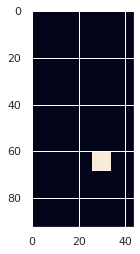

In [18]:
sample= Make_Sample(3,93,44)
# print(sample)
plt.imshow(sample[0][0])

## Training GAN
###### ...is not a simple matter

It depends on architecture, loss, instance noise, augmentation and even luck(recommend to take a look https://arxiv.org/pdf/1801.04406.pdf)


In this notebook I have prepared some basic parts that you could use for your experiments.

#### Small hack that can speed-up training and improve generalization

In [0]:
# from bayes import NoiseLoss,PriorLoss

In [0]:
def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

In [0]:
# class GANLosses(object):
#     def __init__(self, task, device):
#         self.TASK = task
#         self.device = device
def critic(disc_1,disc_2):
    return (torch.norm(disc_1 - disc_2,p=2,dim=-1) - torch.norm(disc_1,p=2,dim=-1)).mean()

def gen_loss_func(disc_real,disc_gen_1,disc_gen_2):
    return (torch.norm(disc_real - disc_gen_1,p=2,dim=-1) + 
            torch.norm(disc_real - disc_gen_2,p=2,dim=-1) -
            torch.norm(disc_gen_1 - disc_gen_2,p=2,dim=-1)
           ).mean()

def calc_gradient_penalty(discriminator, data_gen, inp_data,condition=None, lambda_reg = .1):
        alpha = torch.rand(inp_data.shape[0], 1).to(device)
        dims_to_add = len(inp_data.size()) - 2
        for i in range(dims_to_add):
            alpha = alpha.unsqueeze(-1)
        # alpha = alpha.expand(inp_data.size())

        interpolates = (alpha * inp_data + ((1 - alpha) * data_gen)).to(device)

        interpolates.requires_grad = True

        disc_interpolates,_ = discriminator(interpolates,condition)

        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg
        return gradient_penalty

## Defining discriminator

## Defining generator

In [0]:
# import Label2Image
# from generator import ModelGConvTranspose
# from discriminator import ModelD

In [0]:
def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self,input_size):
        super(ResidualBlock, self).__init__()        
        self.conv1 = nn.Conv2d(input_size,input_size,3,padding=1)
        self.conv2 = nn.Conv2d(input_size,input_size,3,padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv1.out_channels)
        self.bn2 = nn.BatchNorm2d(self.conv2.out_channels)        
        self.activation = nn.LeakyReLU(0.0)
    def forward(self,xraw):
        x = self.activation(self.bn1(self.conv1(xraw)))
        x = self.activation(self.bn2(self.conv2(x))+xraw)
        return x

In [0]:
class ReducedConv(nn.Module):
    def __init__(self,input_size,output_size, input_dim, output_dim,kernel_size):
        super(ReducedConv, self).__init__()
        eps = 1e-3
        scale = float(output_dim+kernel_size-3+eps)/float(input_dim)
        self.ups = nn.Upsample(scale_factor = scale,mode = 'bilinear',align_corners=False )
        self.ref = nn.ReflectionPad2d(1)
        self.conv = nn.Conv2d(input_size,output_size,kernel_size)
        self.in_channels = input_size
        self.out_channels = output_size
    def forward(self,x):
        return self.conv(self.ref(self.ups(x)))

class ReducedConv2(nn.Module):
    def __init__(self,in_channels,out_channels,scale_factor,kernel_size):
        super(ReducedConv2, self).__init__()
        eps = 1e-3
        self.ups = nn.Upsample(scale_factor = scale_factor,mode = 'bilinear',align_corners=False )
        self.ref = nn.ReflectionPad2d(1)
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size)
        self.conv = spectral_norm(self.conv)
        self.in_channels = in_channels
        self.out_channels = out_channels
    def forward(self,x):
        return self.conv(self.ref(self.ups(x)))

In [0]:
def init_weights(net):
    with torch.no_grad(): 
        if type(net) == nn.Linear:
            torch.nn.init.xavier_normal_(net.weight)
            net.bias.data.fill_(0.001)
        if type(net) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(net.weight)
            net.bias.data.fill_(0.001)
        if type(net) == nn.ConvTranspose2d:
            torch.nn.init.xavier_uniform_(net.weight)
            net.bias.data.fill_(0.001)

In [0]:
class Generator(nn.Module):
    def __init__(self,dropout_gen=0., Ndim_cond=0,alpha=0.):
        super(Generator, self).__init__()
        self.Ndim_cond = Ndim_cond
        self.fc1 = nn.Linear(NOISEIMAGE_DIM**2+self.Ndim_cond,256)
        self.fc2 = nn.Linear(self.fc1.out_features,36*64)
        # self.rc1 = ReducedConv(16,8,16,32,3)
        # self.rc2 = ReducedConv(8,4,32,100,3)
        # self.deconv1 = nn.ConvTranspose2d(64,32,stride=2,kernel_size=2)#(6,6)->(12,12)
        # self.deconv2 = nn.ConvTranspose2d(32,16,stride=(3,2),kernel_size=(3,4),padding=(2,1))##(12,12)->(36,24)
        # self.deconv3 = nn.ConvTranspose2d(16,1,stride=(3,2),kernel_size=(6,4),padding=3)##(36,24)->(93,44)
        self.deconv1 = ReducedConv2(64,32,2,4)#(6,6)->(11,11)
        self.deconv2 = ReducedConv2(32,16,(3,2),3)#(11,11)->(33,22)
        self.deconv3 = ReducedConv2(16,1,(3,2),(9,3))#(33,22)->(93,44)
        # self.deconv1 = spectral_norm(self.deconv1)
        # self.deconv2 = spectral_norm(self.deconv2)
        # self.deconv3 = spectral_norm(self.deconv3)
        self.bn1=nn.BatchNorm2d(self.deconv1.out_channels)
        self.bn2=nn.BatchNorm2d(self.deconv2.out_channels)
        self.dropout = nn.Dropout(dropout_gen)
        self.activation  = nn.LeakyReLU(alpha)

    def forward(self,x,condition=None):
        x = x.view(-1,NOISEIMAGE_DIM**2)
        if condition is not None and self.Ndim_cond>0:
            x = torch.cat([x,condition],dim=1)
        
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = x.view(-1,64,6,6)
        x = self.activation(self.dropout(self.bn1(self.deconv1(x))))
        x = self.activation(self.dropout(self.bn2(self.deconv2(x))))
        x = self.deconv3(x)
        return torch.tanh(x)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [0]:
class Discriminator(nn.Module):
    def __init__(self,dropout_conv=0.0, Ndim_cond=0,alpha=0.):
        super(Discriminator, self).__init__()
        # self.rconv1 = ReducedConv(1,Nlayer,)
        self.Ndim_cond = Ndim_cond
        self.conv1 = nn.Conv2d(
            1, 
            16, 
            kernel_size=(6,4), 
            padding = 3,
            stride = (3,2)
        )#(93+4,44+4)->95,46
        self.conv2 = nn.Conv2d(
            self.conv1.out_channels, 
            self.conv1.out_channels*2, 
            kernel_size=(3, 4), 
            stride=(3,2),
            padding=(2,1)
        )#95,46->46*22
        self.conv3 = nn.Conv2d(
            self.conv2.out_channels, 
            self.conv2.out_channels*2, 
            kernel_size=2,
            stride=2
        )#46*22->22,10
        self.conv1 = spectral_norm(self.conv1)
        self.conv2 = spectral_norm(self.conv2)
        self.conv3 = spectral_norm(self.conv3)
        self.lnorm1 = nn.LayerNorm([self.conv1.out_channels,32,24])
        self.lnorm2 = nn.LayerNorm([self.conv2.out_channels,12,12])
        self.lnorm3 = nn.LayerNorm([self.conv3.out_channels,6,6])
        self.fcstart = nn.Linear(self.conv3.out_channels*36+self.Ndim_cond,256)
        self.fcend = nn.Linear(self.fcstart.out_features,1)

        self.dropout1 = nn.Dropout(dropout_conv)
        self.activation  = nn.LeakyReLU(alpha)
        # self.dropoutfc = nn.Dropout(dropout_fc)
        # self.Nresblock = Nresblock
        # self.Nsd = Nsd
        
    def forward(self, x,condition=None):
        x_mppc = x.view(x.shape[0],1,93,44)
        x_mppc = self.activation(self.conv1(x_mppc))
        x_mppc = self.activation(self.dropout1(self.conv2(x_mppc)))
        x_mppc = self.activation(self.dropout1(self.conv3(x_mppc)))
        # x_mppc = F.relu(self.dropout1(self.conv4(x_mppc)))

        x = x_mppc.view(x_mppc.shape[0],-1)
        if condition is not None:
            x = torch.cat([x,condition],dim=1)
        x = self.activation(self.fcstart(x))
        x = self.fcend(x)
        return x,torch.sigmoid(x)
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

## Check our models on one batch 

In [29]:

gens = []
discs = []

if params["conditional"]:
    gen  = Generator(params["dropout_gen"],3,params["alpha"]).to(device)
    disc = Discriminator(params["dropout_conv"],3,params["alpha"]).to(device)
else:
    gen  = Generator(params["dropout_gen"],0,params["alpha"]).to(device)
    disc = Discriminator(params["dropout_conv"],0,params["alpha"]).to(device)

gen.apply(init_weights)
disc.apply(init_weights)

# gen.weight_init(mean=0.0, std=0.02)
# disc.weight_init(mean=0.0, std=0.02)

Discriminator(
  (conv1): Conv2d(1, 16, kernel_size=(6, 4), stride=(3, 2), padding=(3, 3))
  (conv2): Conv2d(16, 32, kernel_size=(3, 4), stride=(3, 2), padding=(2, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (lnorm1): LayerNorm((16, 32, 24), eps=1e-05, elementwise_affine=True)
  (lnorm2): LayerNorm((32, 12, 12), eps=1e-05, elementwise_affine=True)
  (lnorm3): LayerNorm((64, 6, 6), eps=1e-05, elementwise_affine=True)
  (fcstart): Linear(in_features=2307, out_features=256, bias=True)
  (fcend): Linear(in_features=256, out_features=1, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (activation): LeakyReLU(negative_slope=0.1)
)

In [0]:
from torch.optim.lr_scheduler import _LRScheduler

class CosineExpLR(_LRScheduler):
    def __init__(self, optimizer, T_max, eta_min=0, gamma=0.99, last_epoch=-1):
            self.T_max = T_max
            self.eta_min = eta_min
            # self.decayconst = decayconst
            self.gamma = gamma
            super(CosineExpLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.gamma ** self.last_epoch*(self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2)
                for base_lr in self.base_lrs]

In [0]:
# reg_loss = torch.nn.SmoothL1Loss().to(device)
criterion = nn.BCELoss()
# gprior_criterion = PriorLoss(prior_std=1., observed=N)
# gnoise_criterion = NoiseLoss(params=gen.parameters(), noise_std=math.sqrt(2 * gnoise_alpha * learning_rate), observed=N)
# dprior_criterion = PriorLoss(prior_std=1., observed=N)
# dnoise_criterion = NoiseLoss(params=disc.parameters(), noise_std=math.sqrt(2 * dnoise_alpha * learning_rate), observed=N)

## Defining optimiser

In [0]:
if params["optimizer"] == "Adam":
    gen_opt  = optim.Adam(gen.parameters() , lr=params["learning_rate"], betas=(0.9, 0.999), weight_decay=params["weight_decay"])
    disc_opt = optim.Adam(disc.parameters(), lr=params["learning_rate"]*params["lrratio"], betas=(0.9, 0.999), weight_decay=params["weight_decay"])
    # reg_gen_opt = optim.Adam(gen.parameters(), lr=params["learning_rate_reg"], betas=(0.9,0.999))
    # reg_disc_opt = optim.Adam(disc.parameters(), lr=params["learning_rate_reg"], betas=(0.9,0.999))
    
elif params["optimizer"] == "RMSProp":
    gen_opt  = optim.RMSprop(gen.parameters(), lr=params["learning_rate"],weight_decay=params["weight_decay"])
    disc_opt = optim.RMSprop(disc.parameters(), lr=params["learning_rate"]*params["lrratio"],weight_decay=params["weight_decay"])
    # reg_gen_opt = optim.RMSprop(gen.parameters(), lr=params["learning_rate_reg"])
    # reg_disc_opt = optim.RMSprop(disc.parameters(), lr=params["learning_rate_reg"])
    
elif params["optimizer"] == "RMSAdam":
    gen_opt  = optim.Adam(gen.parameters() , lr=params["learning_rate"], betas=(0.9, 0.999), weight_decay=params["weight_decay"])
    disc_opt = optim.RMSprop(disc.parameters(), lr=params["learning_rate"]*params["lrratio"])
    # reg_gen_opt = optim.Adam(gen.parameters(), lr=params["learning_rate_reg"], betas=(0.9,0.999))
    # reg_disc_opt = optim.RMSprop(disc.parameters(), lr=params["learning_rate_reg"])
    


In [0]:
if params["LRtype"]=="Cyclic":
    scheduler_gen = CyclicLR(gen_opt, params["base_lr"],params["learning_rate"],
                         step_size_up=params["stepsize_lr"],
                         step_size_down=params["stepsize_lr_down"],
                         cycle_momentum=False,mode="exp_range",gamma = params["LRgamma"])
    scheduler_disc = CyclicLR(disc_opt, params["base_lr"],params["learning_rate"],
                         step_size_up=params["stepsize_lr"],
                         step_size_down=params["stepsize_lr_down"],
                         cycle_momentum=False,mode="exp_range",gamma = params["LRgamma"])
elif params["LRtype"]=="MStep":
    scheduler_gen = MultiStepLR(gen_opt, milestones=params["milestones"], gamma=params["LRgamma"])
    scheduler_disc = MultiStepLR(disc_opt, milestones=params["milestones"], gamma=params["LRgamma"])
elif params["LRtype"]=="Step":
    scheduler_gen = StepLR(gen_opt,step_size=params["stepsize_lr"],gamma=params["LRgamma"])
    scheduler_disc = StepLR(disc_opt,step_size=params["stepsize_lr"],gamma=params["LRgamma"])
elif params["LRtype"]=="CosA":
    scheduler_gen = CosineAnnealingLR(gen_opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"])
    scheduler_disc = CosineAnnealingLR(disc_opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"])
elif params["LRtype"]=="CosExp":
    scheduler_gen = CosineExpLR(gen_opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"],gamma = params["LRgamma"])
    scheduler_disc = CosineExpLR(disc_opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"],gamma = params["LRgamma"])

## Load scores

In [0]:
# from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
# from sklearn.metrics import auc

In [0]:
# from Regressor import Regressor, load_embedder
# embedder = load_embedder('./embedder.tp')

In [0]:
def D_train(PMResponse_b,ibatch,Condition_b=None,gen_input=None):
    #=======================Train the discriminator=======================#
    
    disc_loss = 0
    disc_real = 0
    disc_fake = 0
    
    # disc_real = raw_real.mean()
    if gen_input is not None:
        PMResponse_gen = gen_input
    else:
        noise = torch.randn(PMResponse_b.shape[0], NOISEIMAGE_DIM, NOISEIMAGE_DIM).to(device)
        PMResponse_gen = gen(noise,Condition_b).to(device)
    
    PMResponse_b   = add_instance_noise(PMResponse_b,params["noiselevel"])
    PMResponse_gen = add_instance_noise(PMResponse_gen,params["noiselevel"])
    raw_real,output_real = disc(PMResponse_b,Condition_b)
    raw_fake,output_fake = disc(PMResponse_gen,Condition_b)
    

    if params["task"]=="WASSERSTEIN":
        disc_real = raw_real.mean()
        disc_fake = raw_fake.mean()
        if params["gp"]:
            if Condition_b is None:
                penalty = calc_gradient_penalty(disc,
                                                PMResponse_gen.data,
                                                PMResponse_b.data,
                                                None,
                                                params["lambda_reg"])
            else:
                penalty = calc_gradient_penalty(disc,
                                                PMResponse_gen.data,
                                                PMResponse_b.data,
                                                Condition_b.data,
                                                params["lambda_reg"])
            disc_loss = disc_fake-disc_real+penalty
            experiment.log_metric("gradient_penalty", penalty.data.item(),step=ibatch)
        else:
            penalty=0
            disc_loss = disc_fake-disc_real
            experiment.log_metric("gradient_penalty", penalty,step=ibatch)
        
        experiment.log_metric("d_real", disc_real.data.item(),step=ibatch)
        experiment.log_metric("d_fake", disc_fake.data.item(),step=ibatch)
        

    elif params["task"] == "CRAMER":
        noise_2 = torch.randn(len(EnergyDeposit_b), NOISEIMAGE_DIM, NOISEIMAGE_DIM).to(device)
        EnergyDeposit_gen_2 = gen(noise_2, ParticleMomentum_ParticlePoint_ParticlePDG_b)
        raw_fake_2,output_fake_2= disc(EnergyDeposit_gen_2.detach(),ParticleMomentum_ParticlePoint_ParticlePDG_b)
        penalty = calc_gradient_penalty(disc,
                                        EnergyDeposit_gen.data,
                                        EnergyDeposit_b.data,
                                        params["lambda_reg"])
        disc_loss = -critic(raw_real, raw_fake_2) + critic(raw_fake, raw_fake_2) + penalty
        experiment.log_metric("gradient_penalty", penalty.data.item(),step=ibatch)
    elif params["task"]=="NORMAL":
        eps=1e-10
        disc_real = F.logsigmoid(raw_real+eps).mean()
        disc_fake = F.logsigmoid(1-raw_fake+eps).mean()
        disc_loss = -disc_real-disc_fake
        # print(disc_loss,disc_real,disc_fake)
        experiment.log_metric("d_real", disc_real.data.item(),step=ibatch)
        experiment.log_metric("d_fake", disc_fake.data.item(),step=ibatch)
    elif params["task"]=="HINGE":
        eps=1e-10
        disc_real = -torch.min(raw_real - 1, torch.zeros(raw_real.shape[0]).to(device)).mean()
        disc_fake = -torch.min(-raw_fake - 1, torch.zeros(raw_fake.shape[0]).to(device)).mean()
        disc_loss = disc_real+disc_fake
        # print(disc_loss,disc_real,disc_fake)
        experiment.log_metric("d_real", disc_real.data.item(),step=ibatch)
        experiment.log_metric("d_fake", disc_fake.data.item(),step=ibatch)
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    # print(disc_loss.data.item())
    
    experiment.log_metric("d_loss", disc_loss.data.item(),step=ibatch)
        
    return

In [0]:
def G_train(PMResponse_b,ibatch,Condition_b=None):
    #=======================Train the generator=======================#
    gen_opt.zero_grad()
    gen_loss = 0
    gen_real = 0
    gen_prior = 0
    gen_noise = 0
    noise = torch.randn(PMResponse_b.shape[0], NOISEIMAGE_DIM,NOISEIMAGE_DIM).to(device)
    PMResponse_gen = gen(noise,Condition_b)
    PMResponse_gen = add_instance_noise(PMResponse_gen,params["noiselevel"])
    
    raw_gen,output_gen = disc(PMResponse_gen,Condition_b)

    if params["task"]=="WASSERSTEIN" or params["task"]=="HINGE":
        gen_real = raw_gen.mean()
        gen_loss = -gen_real
        experiment.log_metric("g_real_loss", gen_real.data.item(),step=ibatch)
    elif params["task"]=="CRAMER":
        raw_real,output_real = disc(EnergyDeposit_b,ParticleMomentum_ParticlePoint_ParticlePDG_b)
        noise_2 = torch.randn(PMResponse_b.shape[0], NOISEIMAGE_DIM, NOISEIMAGE_DIM).to(device)
        EnergyDeposit_gen_2 = gen(noise_2, ParticleMomentum_ParticlePoint_ParticlePDG_b)
        raw_fake_2,output_fake_2 = disc(EnergyDeposit_gen_2.detach(),ParticleMomentum_ParticlePoint_ParticlePDG_b)
        gen_loss = gen_loss_func(raw_real,raw_gen,raw_fake_2)
    elif params["task"]=="NORMAL":
        eps=1e-10
        logp_gen_is_real = F.logsigmoid(raw_gen+eps).mean()
        gen_loss = -logp_gen_is_real
    
    # The generator training wants to maximize the probability that
    # the generated examples are labeled real by the descriminator
    
    # gen_real.backward()
        # gen_loss.data.item(),gen_real.data.item(),gen_prior.data.item(),gen_noise.data.item()
    experiment.log_metric("g_loss", gen_loss.data.item(),step=ibatch)
    
             
    gen_loss.backward()
    gen_opt.step()
    # disc.load(disc_back)
    return PMResponse_gen

In [0]:
def Val_Eval(PMResponse_b,PMResponse_gen,epoch,Condition_b=None):
    
    # PMResponse_gen = add_instance_noise(PMResponse_gen,params["noiselevel"])
    raw_real,output_real = disc(PMResponse_b,Condition_b)
    raw_fake,output_fake = disc(PMResponse_gen,Condition_b)
    disc_real = raw_real.mean()
    disc_fake = raw_fake.mean()
    disc_loss = disc_fake-disc_real
    experiment.log_metric("d_real", disc_real.data.item(),step=epoch)
    experiment.log_metric("d_fake", disc_fake.data.item(),step=epoch)
    experiment.log_metric("d_loss", disc_loss.data.item(),step=epoch)
    return


In [0]:
# LIPSITZ_WEIGHTS = False
# ntrain_d = 1
def run_training(epochs):
    ibatch = 0 
    prd_auc = []  
    for epoch in tqdm(range(epochs)):
        first = True
        with experiment.train():
            experiment.log_metric("learning_rate", scheduler_gen.get_lr(),step=epoch)
            for Energy_b, UVW_b, SHW_b, PMResponse_b in train_loader:
                Energy_b, UVW_b, SHW_b, PMResponse_b = Energy_b.to(device), \
                                                        UVW_b.to(device), \
                                                        SHW_b.to(device), \
                                                        PMResponse_b.to(device)
                # ParticleMomentum_ParticlePoint_ParticlePDG_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device), ParticlePDG_b.to(device)], dim=1)
                if params["test_sample"]:
                    PMResponse_b = Make_Sample(PMResponse_b.shape[0],PMResponse_b.shape[2],PMResponse_b.shape[3]).to(device)
                if params["conditional"]:
                    Condition_b = UVW_b
                else:
                    Condition_b = None
                    
                for itrain in range(params["ntrain_d"]):
                    D_train(PMResponse_b,ibatch,Condition_b)
                PMResponse_gen = G_train(PMResponse_b,ibatch,Condition_b)
                if params["task"]=="WASSERSTEIN" and not params["gp"]:
                    [p.data.clamp_(-params["lipsitzbound"], params["lipsitzbound"]) for p in disc.parameters()]
            
                # break    
                clear_output()
                if ibatch %100 ==2:
                    plt.figure(figsize=(15,12))
                    grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
                    for event in range(3):
                        plt.subplot(grid[0,event])
                        plt.imshow(PMResponse_b[event][0].cpu().detach().numpy(),vmin=0,origin='lower')
                        plt.title("(%f,%f,%f)"%(UVW_b[event][0],UVW_b[event][1],UVW_b[event][2]))
                        plt.colorbar()
                        plt.subplot(grid[1, event])
                        plt.imshow(PMResponse_gen[event][0].cpu().detach().numpy(),vmin=0,origin='lower')
                        plt.title("(%f,%f,%f)"%(UVW_b[event][0],UVW_b[event][1],UVW_b[event][2]))
                        plt.colorbar()
                    
                    experiment.log_figure(figure_name="status%d"%(ibatch),figure=plt,step =ibatch)
                    time.sleep(0.5)
                    plt.close()
    #             plt.show()
                ibatch += 1
        
        with experiment.test():
            for Energy_b, UVW_b, SHW_b, PMResponse_b in validation_loader:
                Energy_b, UVW_b, SHW_b, PMResponse_b = Energy_b.to(device), \
                                                        UVW_b.to(device), \
                                                        SHW_b.to(device), \
                                                        PMResponse_b.to(device)
                if params["test_sample"]:
                    PMResponse_b = Make_Sample(PMResponse_b.shape[0],PMResponse_b.shape[2],PMResponse_b.shape[3]).to(device)
                if params["conditional"]:
                    Condition_b = UVW_b
                else:
                    Condition_b = None
                noise = torch.randn(PMResponse_b.shape[0], NOISEIMAGE_DIM,NOISEIMAGE_DIM).to(device)
                PMResponse_gen = gen(noise,Condition_b).to(device)
                Val_Eval(PMResponse_b,PMResponse_gen,epoch,Condition_b)
                break
            
        scheduler_gen.step()
        scheduler_disc.step()
        



In [0]:
# with experiment.train():
    run_training(params["epochs"])

#### Transfer generator on CPU:

In [0]:
generator_cpu = ModelGConvTranspose(z_dim=NOISEIMAGE_DIM,MomentumPointPDGScale = MomentumPointPDGScale,EnergyScale = EnergyDepositScale)
# generator_cpu.load_state_dict(gen.state_dict())
generator_cpu.load_state_dict(torch.load('/gdrive/My Drive/gan80.pt'))
# generator_cpu.eval()

### Save model on disk

In [0]:
torch.save(generator_cpu.state_dict(), './gan_middle.pt')

## Making predictions

#### Validation predictions

In [0]:
data_val = np.load(val_data_path, allow_pickle=True)
ParticleMomentum_val = torch.tensor(data_val['ParticleMomentum']).float()
ParticlePoint_val = torch.tensor(data_val['ParticlePoint'][:, :2]).float()
ParticlePDG_val = torch.tensor(data_val['ParticlePDG'].reshape(-1,1)).float()
ParticleMomentum_ParticlePoint_ParticlePDG_val = torch.cat([ParticleMomentum_val, ParticlePoint_val,ParticlePDG_val], dim=1)
calo_dataset_val = utils.TensorDataset(ParticleMomentum_ParticlePoint_ParticlePDG_val)
calo_dataloader_val = torch.utils.data.DataLoader(calo_dataset_val, batch_size=1024, shuffle=False)

with torch.no_grad():
    EnergyDeposit_val = []
    for ParticleMomentum_ParticlePoint_ParticlePDG_val_batch in tqdm(calo_dataloader_val):
        noise = torch.randn(len(ParticleMomentum_ParticlePoint_ParticlePDG_val_batch[0]), NOISEIMAGE_DIM,NOISEIMAGE_DIM)
        EnergyDeposit_val_batch = generator_cpu(noise, ParticleMomentum_ParticlePoint_ParticlePDG_val_batch[0]).detach().numpy()
        EnergyDeposit_val.append(EnergyDeposit_val_batch)
    np.savez_compressed('./data_val_prediction.npz', 
                        EnergyDeposit=np.concatenate(EnergyDeposit_val, axis=0).reshape(-1, 30, 30))

    del EnergyDeposit_val
del data_val; del ParticleMomentum_val; del ParticlePoint_val; del ParticleMomentum_ParticlePoint_ParticlePDG_val;
del calo_dataset_val; calo_dataloader_val

#### Test predictions

In [0]:
data_test = np.load(test_data_path, allow_pickle=True)
ParticleMomentum_test = torch.tensor(data_test['ParticleMomentum']).float()
ParticlePoint_test = torch.tensor(data_test['ParticlePoint'][:, :2]).float()
ParticlePDG_test = torch.tensor(data_test['ParticlePDG'].reshape(-1,1)).float()
ParticleMomentum_ParticlePoint_ParticlePDG_test = torch.cat([ParticleMomentum_test, ParticlePoint_test, ParticlePDG_test], dim=1)
calo_dataset_test = utils.TensorDataset(ParticleMomentum_ParticlePoint_ParticlePDG_test)
calo_dataloader_test = torch.utils.data.DataLoader(calo_dataset_test, batch_size=1024, shuffle=False)

with torch.no_grad():
    EnergyDeposit_test = []
    for ParticleMomentum_ParticlePoint_ParticlePDG_test_batch in tqdm(calo_dataloader_test):
        noise = torch.randn(len(ParticleMomentum_ParticlePoint_ParticlePDG_test_batch[0]), NOISE_DIM)
        EnergyDeposit_test_batch = generator_cpu(noise, ParticleMomentum_ParticlePoint_ParticlePDG_test_batch[0]).detach().numpy()
        EnergyDeposit_test.append(EnergyDeposit_test_batch)
    np.savez_compressed('./data_test_prediction.npz', 
                        EnergyDeposit=np.concatenate(EnergyDeposit_test, axis=0).reshape(-1, 30, 30))

    del EnergyDeposit_test
del data_test; del ParticleMomentum_test; del ParticlePoint_test; del ParticleMomentum_ParticlePoint_ParticlePDG_test;
del calo_dataset_test; calo_dataloader_test

## `zip-zip` files together

In [0]:
!zip solution.zip data_val_prediction.npz data_test_prediction.npz

In [0]:
from IPython.display import FileLink
FileLink('./solution.zip')

# A few words about metrics

### Lets generate some fake data

In [0]:
for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, ParticlePDG_b in validation_loader:
    break

In [0]:
noise = torch.randn(len(ParticleMomentum_b), NOISE_DIM)
with torch.no_grad():
    ParticleMomentum_ParticlePoint_ParticlePDG = torch.cat([ParticleMomentum_b, 
                                                ParticlePoint_b,
                                                ParticlePDG_b], dim=1)
    EnergyDeposit_gen = generator_cpu(noise, ParticleMomentum_ParticlePoint_ParticlePDG.cpu())

In [0]:
EnergyDeposit_gen = EnergyDeposit_gen.detach().cpu().numpy().reshape(-1, 30, 30)
EnergyDeposit_b = EnergyDeposit_b.detach().cpu().numpy().reshape(-1, 30, 30)

#### Plot one image

In [0]:
plt.figure()
plt.imshow(EnergyDeposit_gen[2])
plt.colorbar()

## Calculate PRD score between these batch 

In [0]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.batchnorm0 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 16, 2, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 2, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 2, stride=2)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 2)
        
        self.dropout = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(256, 256) 
        self.batchnorm4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2 + 3)
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.batchnorm0(self.dropout(x))
        x = self.batchnorm1(self.dropout(F.relu(self.conv1(x))))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1)
        x = self.dropout(x)
        x = self.batchnorm4(self.dropout(F.relu(self.fc1(x))))
        x = F.leaky_relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return self.fc4(x), self.fc5(x)
    
    def get_encoding(self, x):
        x = self.batchnorm0(self.dropout(x))
        x = self.batchnorm1(self.dropout(F.relu(self.conv1(x))))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1)
        x = self.dropout(x)
        x = self.batchnorm4(self.dropout(F.relu(self.fc1(x))))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

def load_embedder(path):
    embedder = torch.load(path)
    embedder.eval()
    return embedder

embedder = load_embedder('./embedder.tp')

In [0]:
data_real = embedder.get_encoding(torch.tensor(EnergyDeposit_b).float().view(-1, 1, 30, 30)).detach().numpy()
data_fake = embedder.get_encoding(torch.tensor(EnergyDeposit_gen).float().view(-1, 1, 30, 30)).detach().numpy()

In [0]:
def plot_pr_aucs(precisions, recalls):
    plt.figure(figsize=(12, 12))
    pr_aucs = []
    for i in range(len(recalls)):
        plt.step(recalls[i], precisions[i], color='b', alpha=0.2,  label='PR-AUC={}'.format(auc(precisions[i], recalls[i])))
        pr_aucs.append(auc(precisions[i], recalls[i]))
    plt.step(np.mean(recalls, axis=0), np.mean(precisions, axis=0), color='r', alpha=1,  label='average')
    plt.fill_between(np.mean(recalls, axis=0), 
                     np.mean(precisions, axis=0) - np.std(precisions, axis=0) * 3,
                     np.mean(precisions, axis=0) + np.std(precisions, axis=0) * 3, color='g', alpha=0.2,  label='std')

    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # plt.ylim([0.0, 1.05])
    # plt.xlim([0.0, 1.0])
    print(np.mean(pr_aucs), np.std(pr_aucs))
    plt.legend()
    
    return pr_aucs

def calc_pr_rec(data_real, data_fake, num_clusters=20, num_runs=10, NUM_RUNS=10):
    precisions = []
    recalls = []
    for i in tqdm(range(NUM_RUNS)):
        precision, recall = compute_prd_from_embedding(data_real, data_fake, num_clusters=num_clusters, num_runs=num_runs)
        precisions.append(precision)
        recalls.append(recall)
    return precisions, recalls

In [0]:
precisions, recalls = calc_pr_rec(data_real, data_fake, num_clusters=100, num_runs=20)

In [0]:
pr_aucs = plot_pr_aucs(precisions, recalls)
plt.title('Num_clusters={}, num_runs={}, first third'.format(100, 20))
plt.show()

In [0]:
pr_aucs

## Physical metrics

In [0]:
import matplotlib.lines as mlines
def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

def plot_axes_for_shower(ecal, point, p):
    x = np.linspace(-14.5, 14.5, 30)
    y = np.linspace(-14.5, 14.5, 30)

    xx, yy = np.meshgrid(x, y)
    zoff = 25.
    ipic = 3
    orth = np.array([-p[1], p[0]])

    pref = point[:2] + p[:2] * zoff / p[2]

    p1 = pref - 10 * p[:2]
    p2 = pref + 10 * p[:2]
    p3 = pref - 10 * orth
    p4 = pref + 10 * orth

    plt.contourf(xx, yy, np.log(ecal + 1), cmap=plt.cm.inferno)
    newline(p1, p2)
    newline(p3, p4)
    plt.colorbar()

In [0]:
idx = 2
plot_axes_for_shower(EnergyDeposit[idx], point=ParticlePoint[idx].detach().numpy(),
                     p=ParticleMomentum[idx].detach().numpy())

In [0]:
from calogan_metrics import get_assymetry, get_shower_width, get_sparsity_level

In [0]:
assym = get_assymetry(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=False)
assym_ortho = get_assymetry(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=True)
sh_width = get_shower_width(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=False)
sh_width_ortho = get_shower_width(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=True)
sparsity_level = get_sparsity_level(EnergyDeposit)

## Longitudual cluster asymmetry

In [0]:
sns.set(font_scale=2)
plt.hist(assym, bins=50, range=[-1, 1], color='red', alpha=0.3, normed=True, label='MC');
plt.xlabel('Longitudual cluster asymmetry')
plt.legend(loc='best')

## Transverse cluster asymmetry

In [0]:
sns.set(font_scale=2)
plt.hist(assym_ortho, bins=50, range=[-1, 1], color='red', alpha=0.3, normed=True, label='MC');
plt.xlabel('Transverse cluster asymmetry')
plt.legend(loc='best')

## Cluster longitudual width

In [0]:
plt.hist(sh_width, bins=50, range=[0, 15], normed=True, alpha=0.3, color='red', label='MC');
plt.title('Shower longitudial width')
plt.legend(loc='best')
plt.xlabel('Cluster longitudual width [cm]')
plt.ylabel('Arbitrary units')

## Cluster trasverse width

In [0]:
plt.hist(sh_width_ortho, bins=50, range=[0,10], normed=True, alpha=0.3, color='blue', label='MC');
#plt.title('Shower transverse width')
plt.legend(loc='best')
plt.xlabel('Cluster trasverse width [cm]')
plt.ylabel('Arbitrary units')

## Sparsity

In [0]:
alphas = np.log(np.logspace(-5, -1, 20))
means_r = np.mean(sparsity_level, axis=1)
stddev_r = np.std(sparsity_level, axis=1)

In [0]:
plt.plot(alphas, means_r, color='red')
plt.fill_between(alphas, means_r-stddev_r, means_r+stddev_r, color='red', alpha=0.3)
plt.legend(['MC'])
plt.title('Sparsity')
plt.xlabel('log10(Threshold/GeV)')
plt.ylabel('Fraction of cells above threshold')

In [0]:
from calogan_metrics import get_physical_stats
real_phys_stats = get_physical_stats(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy())
gen_phys_stats = get_physical_stats(EnergyDeposit_gen, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy())

In [0]:
precisions, recalls = calc_pr_rec(real_phys_stats, gen_phys_stats, num_clusters=100, num_runs=20)

In [0]:
pr_aucs = plot_pr_aucs(precisions, recalls)
plt.title('Num_clusters={}, num_runs={}, first third'.format(100, 20))
plt.show()

In [0]:
pr_aucs